##### This case is quite interesting:

Knapsack(values=[4 4], weights=[1 1], capacity=1)

In [1]:
import numpy as np
from scipy.linalg import expm
import scipy
import matplotlib.pyplot as plt
import time

In [2]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

In [3]:
sigmaI = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
sigmaX = np.array(
    [
        [0, 1],
        [1, 0],
    ]
)
sigmaBin = np.array(
    [
        [0, 0],
        [0, 1],
    ]
)

In [4]:
Values = [4, 4]
Weights = [1, 1]
Ancil = [1]
# correct solution: 10010 or 10001
num_dimension = 2**(len(Values) + len(Ancil))

alpha = 1000
beta = 1
gamma = max(Values) + 1
T = 1
dt = 0.01
t_axis = np.arange(0, T, dt)[0:]

In [5]:
# Create creation operator
a_dag = np.zeros((num_dimension, num_dimension))
n_indices = np.arange(num_dimension - 1)
a_dag[n_indices + 1, n_indices] = np.sqrt(n_indices + 1)
# print(a_dag)

# Create annihilation operator
a = np.zeros((num_dimension, num_dimension))
n_indices = np.arange(1, num_dimension)
a[n_indices - 1, n_indices] = np.sqrt(n_indices)
# print(a)

# print(a_dag @ a)

In [6]:
H0 = (a_dag + a)
# print(H0)

eigenvals_H0, eigenvecs_H0 = np.linalg.eigh(H0)
ground_idx_H0 = eigenvals_H0.argsort()[0]
print(eigenvals_H0[ground_idx_H0])
print(eigenvecs_H0[:, ground_idx_H0])

-4.144547186125894
[-0.011  0.044 -0.121  0.255 -0.422  0.555 -0.554  0.354]


In [7]:
eyes = [sigmaI for _ in range(len(Values) + len(Ancil))]
profit_matrix = np.zeros((num_dimension, num_dimension))
weight_matrix = np.zeros((num_dimension, num_dimension))
penalty_matrix = np.zeros((num_dimension, num_dimension))

for i in range(len(Values)):
    nose = eyes.copy()
    nose[i] = sigmaBin
    tensorproduct = nose[0]
    for sigma in nose[1:]:
        tensorproduct = np.kron(tensorproduct, sigma)
    profit_matrix += Values[i] * tensorproduct
    weight_matrix += Weights[i] * tensorproduct
    
for j in range(len(Ancil)):
    nose = eyes.copy()
    nose[j + len(Values)] = sigmaBin
    tensorproduct = nose[0]
    for sigma in nose[1:]:
        tensorproduct = np.kron(tensorproduct, sigma)
    penalty_matrix += Ancil[j] * tensorproduct

Hp = -profit_matrix + gamma * (weight_matrix - penalty_matrix)**2


eigenvals_Hp, eigenvecs_Hp = np.linalg.eigh(Hp)
print(eigenvals_Hp)
print(eigenvals_Hp.argsort())
ground_idx_Hp = eigenvals_Hp.argsort()[0]
ground_idx_Hp_degen = eigenvals_Hp.argsort()[1]
print(eigenvals_Hp[ground_idx_Hp])
print(eigenvecs_Hp[:, ground_idx_Hp])
print(eigenvals_Hp[ground_idx_Hp_degen])
print(eigenvecs_Hp[:, ground_idx_Hp_degen])



[-4. -4. -3.  0.  1.  1.  5. 12.]
[0 1 2 3 4 5 6 7]
-4.0
[0. 0. 0. 1. 0. 0. 0. 0.]
-4.0
[0. 0. 0. 0. 0. 1. 0. 0.]


In [8]:
def H(t, T=1, alpha=1, beta=1):
    return alpha * ( (1 - t/T)*beta*H0 + (t/T)*Hp )

In [9]:
psi_ini = eigenvecs_H0[:, ground_idx_H0]
# print(psi_ini)
# print(np.linalg.norm(psi_ini))

psi_correct = eigenvecs_Hp[:, ground_idx_Hp]
if eigenvals_Hp[ground_idx_Hp] == eigenvals_Hp[ground_idx_Hp_degen]:
    psi_correct_degen = eigenvecs_Hp[:, ground_idx_Hp_degen]
else:    
    psi_correct_degen = np.zeros(eigenvecs_Hp[:, ground_idx_Hp_degen].shape)
print(psi_correct)
print(psi_correct_degen)

[0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0.]


In [ ]:
alpha = 1000
beta = 1
T = 1
accuracy_list = []
# T_list = np.arange(0, 100, 1)
T_list = np.power(1.5, np.arange(0, 25, 1))

for T in T_list:
    start_time = time.time()

    t_axis = np.arange(0, T, dt)
    junrui_unitary = np.identity(len(H0))
    for t in t_axis:
        junrui_unitary = expm(-1j * H(t, alpha=alpha, beta=beta, T=T) * dt) @ junrui_unitary

    psi_final = junrui_unitary @ psi_ini

    accuracy = np.abs( np.dot(psi_correct, psi_final) )**2 + np.abs( np.dot(psi_correct_degen, psi_final) )**2
    accuracy_list.append(accuracy)

    end_time = time.time()
    print(f"T = {T}, loop time: {end_time - start_time}, accuracy: {accuracy}")

print(accuracy_list)
# plt.scatter(alpha_list, accuracy_list, s=1)
plt.scatter(T_list, accuracy_list, s=1)
plt.xlabel("T")
plt.ylabel("accuracy")
print(max(accuracy_list))

T = 1.0, loop time: 0.0659949779510498, accuracy: 0.9882508627695663
T = 1.5, loop time: 0.02852606773376465, accuracy: 0.9871981718632524
T = 2.25, loop time: 0.029931068420410156, accuracy: 0.989733439967784
T = 3.375, loop time: 0.04042482376098633, accuracy: 0.9974881761201468
T = 5.0625, loop time: 0.09418082237243652, accuracy: 0.9972520199437955
T = 7.59375, loop time: 0.10819101333618164, accuracy: 0.9991806425306775
T = 11.390625, loop time: 0.11966300010681152, accuracy: 0.997803040329902
T = 17.0859375, loop time: 0.19008994102478027, accuracy: 0.9996262616879095
T = 25.62890625, loop time: 0.528717041015625, accuracy: 0.9999139271804078
T = 38.443359375, loop time: 0.41530609130859375, accuracy: 0.9999057108109397
T = 57.6650390625, loop time: 0.9260141849517822, accuracy: 0.9999356764479803
T = 86.49755859375, loop time: 0.8506240844726562, accuracy: 0.999834073499362
T = 129.746337890625, loop time: 1.2480368614196777, accuracy: 0.9999612181736182
T = 194.6195068359375, l

KeyboardInterrupt: 

0.9999984077593254


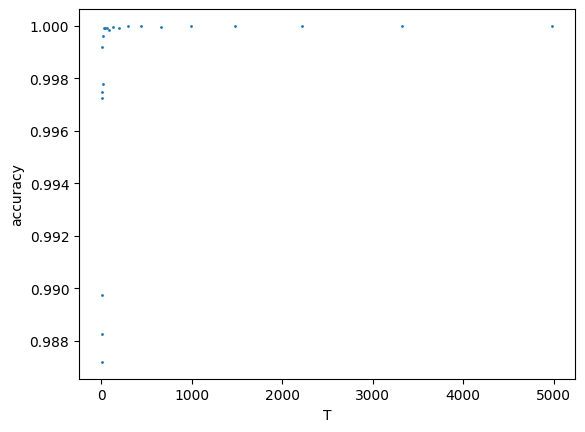

In [11]:
plt.scatter(T_list[0:len(accuracy_list)], accuracy_list, s=1)
plt.xlabel("T")
plt.ylabel("accuracy")
print(max(accuracy_list))